In [1]:
import torch
import sparrow
import protfasta
import glob
from pathlib import Path
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
import os

In [2]:
fasta = protfasta.read_fasta("/home/borna/packages/internal/starling/borna/SI_figures/dataset_analysis/original_dataset/train.fasta")
fasta = {str(Path(k).with_suffix('')): v for k, v in fasta.items()}

In [3]:
# Path for the cached pickle file
cache_file = "/work/bnovak/projects/sequence2ensemble/lammps_data/150mM_data/sequence_embeddings/embeddings/all_train_embeddings.pkl"

# Check if cache exists
if os.path.exists(cache_file):
    print(f"Loading embeddings from cache file...")
    with open(cache_file, 'rb') as f:
        sequence_embeddings = pickle.load(f)
else:
    # Original loading code
    print("Cache not found. Loading individual embedding files...")
    
    embedding_path = '/work/bnovak/projects/sequence2ensemble/lammps_data/150mM_data/sequence_embeddings/embeddings'
    embeddings = glob.glob(embedding_path + '/*.pt')
    sequence_embeddings = {}
    
    for embedding in tqdm(embeddings):
        data = torch.load(embedding)
        name = Path(Path(embedding).stem).with_suffix('')
        sequence_embeddings[str(name)] = data.mean(axis=0).numpy()

Loading embeddings from cache file...


In [5]:
rg = {key: sparrow.Protein(value).predictor.radius_of_gyration() for key, value in fasta.items() if key in sequence_embeddings.keys()}
re = {key: sparrow.Protein(value).predictor.end_to_end_distance() for key, value in fasta.items() if key in sequence_embeddings.keys()}

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/sparrow/predictors/scaled_rg/scaled_radius_of_gyration_predictor.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [67]:
train, test = train_test_split(list(sequence_embeddings.keys()), test_size=0.2, random_state=42)

train_embeddings = np.array([sequence_embeddings[k] for k in train])
train_rg = np.array([rg[k] for k in train])
train_re = np.array([re[k] for k in train])
test_embeddings = np.array([sequence_embeddings[k] for k in test])
test_rg = np.array([rg[k] for k in test])
test_re = np.array([re[k] for k in test])

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data only
train_embeddings_scaled = scaler.fit_transform(train_embeddings)

# Transform test data using the same scaler
test_embeddings_scaled = scaler.transform(test_embeddings)

Training MSE: 0.8954
Training R²: 0.9956
Test MSE: 0.9795
Test R²: 0.9951


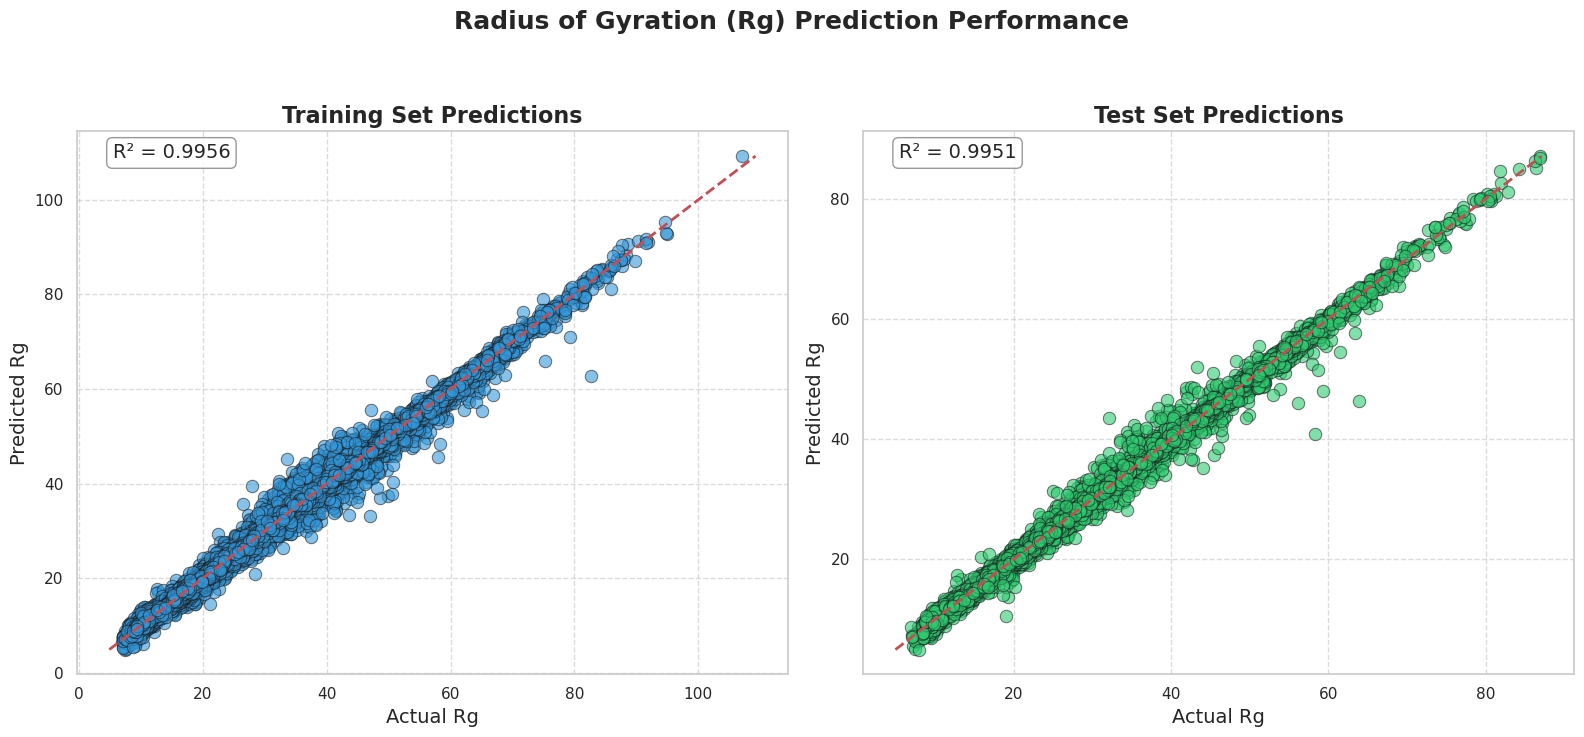

In [68]:
# Train a linear regression model
model = LinearRegression()
model.fit(train_embeddings_scaled, train_rg)

# Predict on training and test data
train_predictions = model.predict(train_embeddings_scaled)
test_predictions = model.predict(test_embeddings_scaled)

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

train_mse = mean_squared_error(train_rg, train_predictions)
train_r2 = r2_score(train_rg, train_predictions)
test_mse = mean_squared_error(test_rg, test_predictions)
test_r2 = r2_score(test_rg, test_predictions)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Plot actual vs predicted values in a nicer format
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Training data plot
sns.scatterplot(x=train_rg, y=train_predictions, alpha=0.6, color='#3498db', 
                edgecolor='k', s=80, ax=ax1)
min_val = min(min(train_rg), min(train_predictions))
max_val = max(max(train_rg), max(train_predictions))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax1.set_xlabel('Actual Rg', fontsize=14)
ax1.set_ylabel('Predicted Rg', fontsize=14)
ax1.set_title('Training Set Predictions', fontsize=16, fontweight='bold')
ax1.annotate(f'R² = {train_r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=14, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
ax1.grid(True, linestyle='--', alpha=0.7)

# Test data plot
sns.scatterplot(x=test_rg, y=test_predictions, alpha=0.6, color='#2ecc71', 
                edgecolor='k', s=80, ax=ax2)
min_val = min(min(test_rg), min(test_predictions))
max_val = max(max(test_rg), max(test_predictions))
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_xlabel('Actual Rg', fontsize=14)
ax2.set_ylabel('Predicted Rg', fontsize=14)
ax2.set_title('Test Set Predictions', fontsize=16, fontweight='bold')
ax2.annotate(f'R² = {test_r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=14, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
ax2.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Radius of Gyration (Rg) Prediction Performance', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

Training MSE: 16.5300
Training R²: 0.9856
Test MSE: 17.9839
Test R²: 0.9841


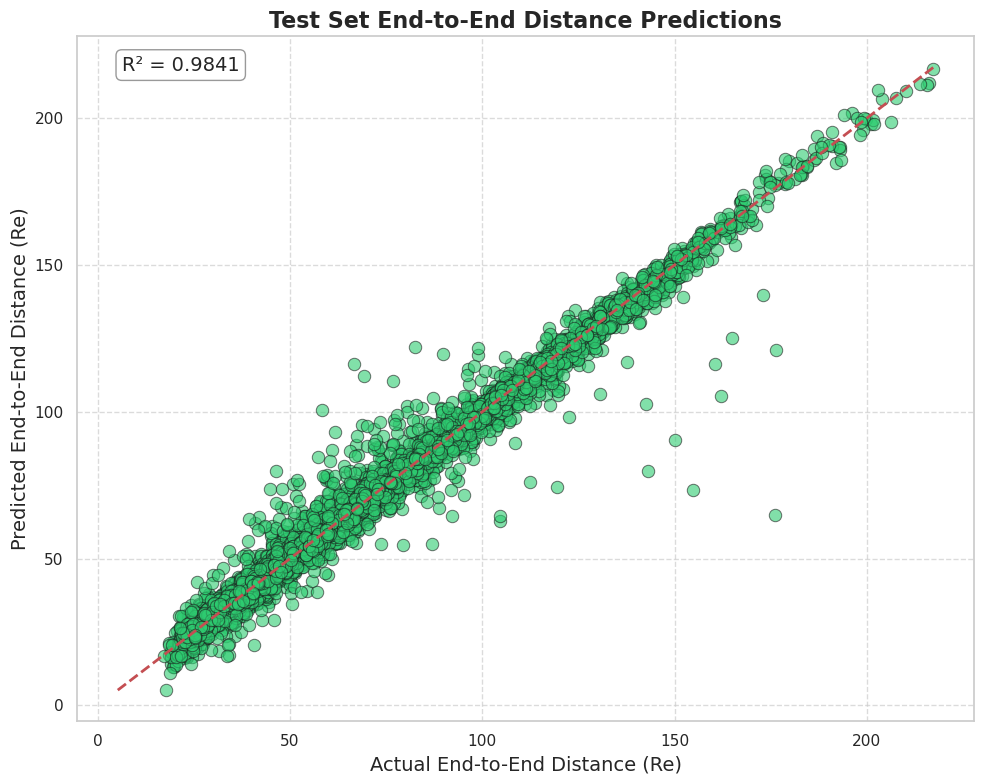

In [10]:
# Train a linear regression model
model = LinearRegression()
model.fit(train_embeddings_scaled, train_re)

# Predict on training and test data
train_predictions = model.predict(train_embeddings_scaled)
test_predictions = model.predict(test_embeddings_scaled)

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

train_mse = mean_squared_error(train_re, train_predictions)
train_r2 = r2_score(train_re, train_predictions)
test_mse = mean_squared_error(test_re, test_predictions)
test_r2 = r2_score(test_re, test_predictions)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Create a single, nice plot for the test data only
plt.figure(figsize=(10, 8))

# Test data plot with enhanced styling
sns.scatterplot(x=test_re, y=test_predictions, alpha=0.6, color='#2ecc71', 
                edgecolor='k', s=80)

# Add the ideal line
min_val = min(min(test_re), min(test_predictions))
max_val = max(max(test_re), max(test_predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

# Enhance labels and title
plt.xlabel('Actual End-to-End Distance (Re)', fontsize=14)
plt.ylabel('Predicted End-to-End Distance (Re)', fontsize=14)
plt.title('Test Set End-to-End Distance Predictions', fontsize=16, fontweight='bold')

# Add R² value on the plot
plt.annotate(f'R² = {test_r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=14, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add grid and adjust layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

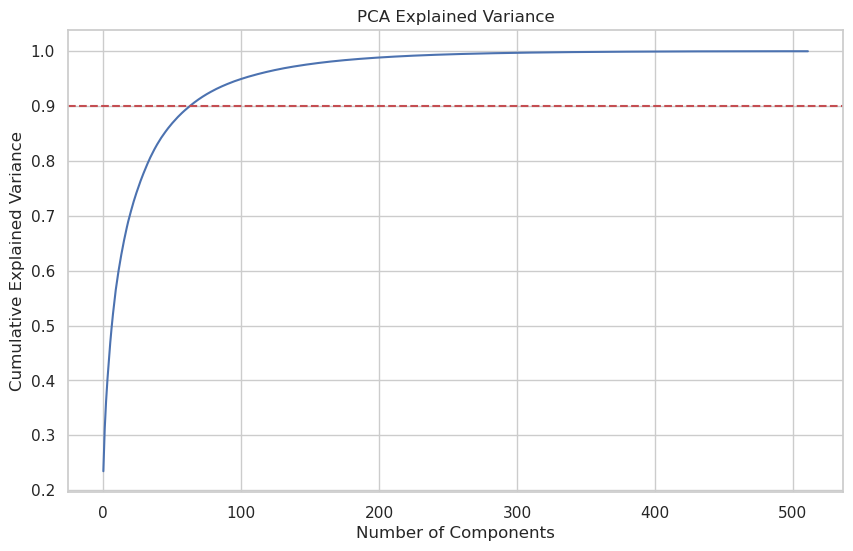

Number of components for 90% variance: 64


In [105]:
# Determine optimal number of components by analyzing explained variance
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(np.array(list(sequence_embeddings.values())))

# First run PCA to analyze explained variance
pca = PCA().fit(embeddings_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--')  # 90% threshold line
plt.title('PCA Explained Variance')
plt.show()

# Find number of components needed for 90% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Number of components for 90% variance: {n_components}")

# Apply PCA with optimal components
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_scaled)

# Now normalize these PCA components if you want to use cosine similarity
embeddings_pca_normalized = normalize(embeddings_pca)


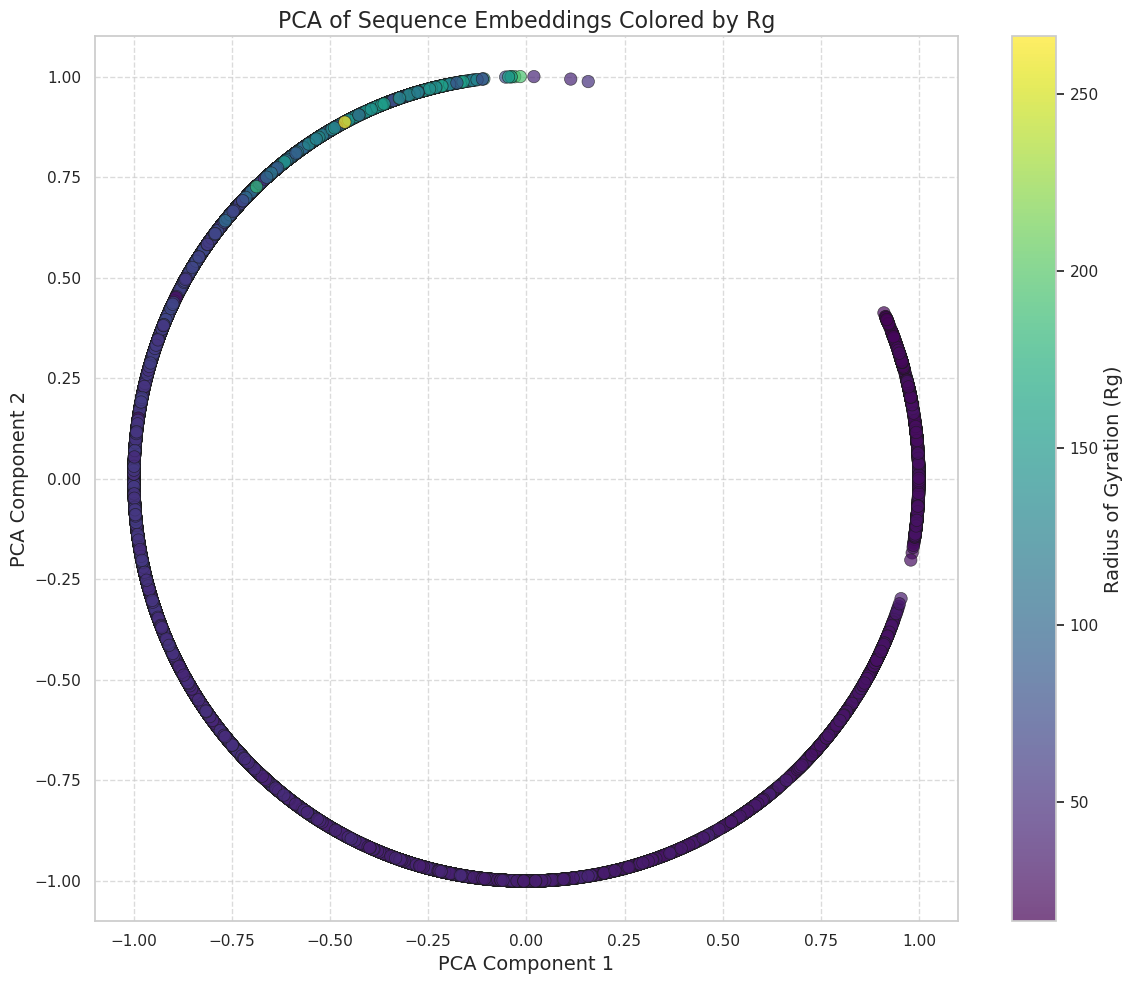

In [106]:
# Create a scatter plot of the first two PCA components colored by Rg values
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create an array of Rg values in the same order as embeddings_pca_normalized
rg_values = np.array([re.get(name, np.nan) for name in list(sequence_embeddings.keys())])

# Set up a clean figure
plt.figure(figsize=(12, 10))

# Use a nice colormap - 'viridis' is good for continuous data
scatter = plt.scatter(embeddings_pca_normalized[:, 0], 
                     embeddings_pca_normalized[:, 1], 
                     c=rg_values,
                     cmap='viridis', 
                     alpha=0.7,
                     s=80,
                     edgecolors='k',
                     linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, label='Radius of Gyration (Rg)')
cbar.set_label('Radius of Gyration (Rg)', fontsize=14)

# Improve axes and title
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.title('PCA of Sequence Embeddings Colored by Rg', fontsize=16)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
fasta

{'Q96PZ7_3321_3354': 'MKWTGKSPVCKSKGVREVNETVTKTPVPSDVFFV',
 'Q96Q89_217_266': 'SALLRQIKEVTVHNDSDDTLYGSLTNSLNISEFEESIKDYEQANLNMANS',
 'Q96NA2_308_401': 'TPEEAESSEDEAGPWILLSDDKGDHPPPPESKIQSFFGLWYRGKAESSEDETSSPAPSKLGGEEEAQPQSPAPDPPCSALHEHLCLGASAAPEA',
 'Q96Q15_3041_3074': 'KTLSGSSSLEDQNTVNGPVQIVNVKTLFRNSCFS',
 'Q96QE5_1_64': 'MSGSVLFTAGERWRCFLTPSRSSLYWALHNFCCRKKSTTPKKITPNVTFCDENAKEPENALDKL',
 'Q96NL0_79_109': 'KEISQSCRWLAHLQIPLQGQVTWFGYESPRS',
 'Q96N23_1_66': 'MAAQGSPSSSPSDDSTTSGSLPELPPTSTATSRSPPESKGSSRSSLLQWTCPEDSLPLAVFYGPLD',
 'Q96MP5_421_500': 'DYIDFFNTKGLKNLPTPPPKLKRARPASMPLKSKKAFGICGESLTSLPAEETKPDAQQVQVQQQSQVPPSQVGMLDTLHQ',
 'Q96PL2_118_161': 'SFSCTYHSTYLVNQAAFDQRVATVHVKNGSMGTFESQLSLNFYT',
 'Q96M95_1_48': 'MSLGIMEEEDLAEYFRLQYGERLLQMLQKLPNVEGASESPSIWLLEKK',
 'Q96PQ6_100_227': 'VGKPSLISHLEQEEEPRTEERGAHQGACADWETPSKTKWSLLMEDIFGKETPSGVTMERAGLGEKSTEYAHLFEVFGMDPHLTQPMGRHAGKRPYHRRDYGVAFKGRPHLTQHMSMYDGRKMHECHQC',
 'Q96QK8_1_99': 'MAEGGFDPCECVCSHEHAMRRLINLLRQSQSYCTDTECLQELPGPSGDNGISVTMILVAWMVI

In [41]:
import torch
import numpy as np

# Select a sequence to query
# name = 'Q9UIX4_180_214'
name = 'Q9UIF9_1608_1641'

# Get the query embedding as a tensor
query_emb = torch.tensor(sequence_embeddings[name], dtype=torch.float32).reshape(1, -1)

# Convert all embeddings to tensors and keep track of names
# all_names = list(sequence_embeddings.keys())
all_names = [key for key in sequence_embeddings if len(fasta[name]) -10 < len(fasta[key]) < len(fasta[name]) + 10]
all_embeddings = torch.tensor(np.array([sequence_embeddings[n] for n in all_names]), dtype=torch.float32)

# Calculate L2 distances between query and all embeddings
dists = torch.cdist(query_emb, all_embeddings)[0]  # shape: [num_sequences]

# Get top 10 closest sequences (excluding the query itself)
# First create a mask to exclude the query sequence
mask = torch.ones_like(dists, dtype=torch.bool)
query_idx = all_names.index(name)
mask[query_idx] = False

# Apply mask and get top 10
masked_dists = dists.masked_select(mask)
masked_indices = torch.nonzero(mask).squeeze()
top_k = 10
topk_values, topk_indices = masked_dists.topk(top_k, largest=False)

# Map back to original indices and names
original_indices = masked_indices[topk_indices]
closest_names = [all_names[idx.item()] for idx in original_indices]
closest_distances = topk_values.tolist()

sequences_closest = []
rgs_closest = []
res_closest = []

# Print results
print(f"Query sequence: {name}")
print("\nTop 10 closest sequences (L2 distance):")
for i, (seq_name, dist) in enumerate(zip(closest_names, closest_distances)):
    print(f"{i+1}. {seq_name}: {dist:.4f}")
    
    # Print details about the sequence if available
    if seq_name in fasta:
        print(f"   Sequence: {fasta[seq_name][:30]}..." if len(fasta[seq_name]) > 30 else f"   Sequence: {fasta[seq_name]}")
        sequences_closest.append(fasta[seq_name])
    if seq_name in rg:
        print(f"   Rg: {rg[seq_name]:.4f}")
        rgs_closest.append(rg[seq_name])
    if seq_name in re:
        print(f"   Re: {re[seq_name]:.4f}")
        res_closest.append(re[seq_name])
    print()
    
topk_values, topk_indices = masked_dists.topk(top_k, largest=True)

# Map back to original indices and names
original_indices = masked_indices[topk_indices]
closest_names = [all_names[idx.item()] for idx in original_indices]
closest_distances = topk_values.tolist()

sequences_far = []
rgs_far = []
res_far = []

# Print results
print(f"Query sequence: {name}")
print("\nTop 10 closest sequences (L2 distance):")
for i, (seq_name, dist) in enumerate(zip(closest_names, closest_distances)):
    print(f"{i+1}. {seq_name}: {dist:.4f}")
    
    # Print details about the sequence if available
    if seq_name in fasta:
        print(f"   Sequence: {fasta[seq_name][:30]}..." if len(fasta[seq_name]) > 30 else f"   Sequence: {fasta[seq_name]}")
        sequences_far.append(fasta[seq_name])
    if seq_name in rg:
        print(f"   Rg: {rg[seq_name]:.4f}")
        rgs_far.append(rg[seq_name])
    if seq_name in re:
        print(f"   Re: {re[seq_name]:.4f}")
        res_far.append(re[seq_name])
    print()

Query sequence: Q9UIF9_1608_1641

Top 10 closest sequences (L2 distance):
1. IDR_2701_tr___A0A0G2JFQ4___A0A0G2JFQ4_MOUSE: 12.0494
   Sequence: QPQEAEAGPCETHDLVGPELTSGRNTQGLL...
   Rg: 16.5620
   Re: 40.5588

2. Q92597_1_34: 12.1963
   Sequence: MSREMQDVDLAEVKPLVEKGETITGLLQEF...
   Rg: 16.8119
   Re: 41.7079

3. IDR_13160_sp___Q9P6I8___YHG1_SCHPO: 13.3701
   Sequence: MEYLTNLKTNIMDKQLGHREVSEGSTQPKP...
   Rg: 16.4054
   Re: 40.2884

4. A6NI72_129_162: 13.6297
   Sequence: PTDNQTKKPETYLMPKDGKSTATDITGPII...
   Rg: 16.8484
   Re: 41.9366

5. P49790_819_852: 13.6458
   Sequence: EKPGSSVPASSSSTVPVSLPSGGSLGLEKF...
   Rg: 16.8884
   Re: 42.0192

6. P50613_313_346: 14.1057
   Sequence: PVETLKEQSNPALAIKRKRTEALEQGGLPK...
   Rg: 16.6673
   Re: 40.7229

7. Q96PZ7_3321_3354: 14.3407
   Sequence: MKWTGKSPVCKSKGVREVNETVTKTPVPSD...
   Rg: 16.6846
   Re: 40.5419

8. IDR_13969_tr___A0A075B5Q8___A0A075B5Q8_MOUSE: 14.4444
   Sequence: MAVLGLLLCLVTFPSCVLSQVQMKESGPDL...
   Rg: 17.0538
   Re: 42.4348

9. P5529

In [46]:
sparrow.Protein(fasta[name]).show_sequence()

In [48]:
[sparrow.Protein(i).show_sequence() for i in sequences_far]


[None, None, None, None, None, None, None, None, None, None]

In [47]:
[sparrow.Protein(i).show_sequence() for i in sequences_closest]

[None, None, None, None, None, None, None, None, None, None]

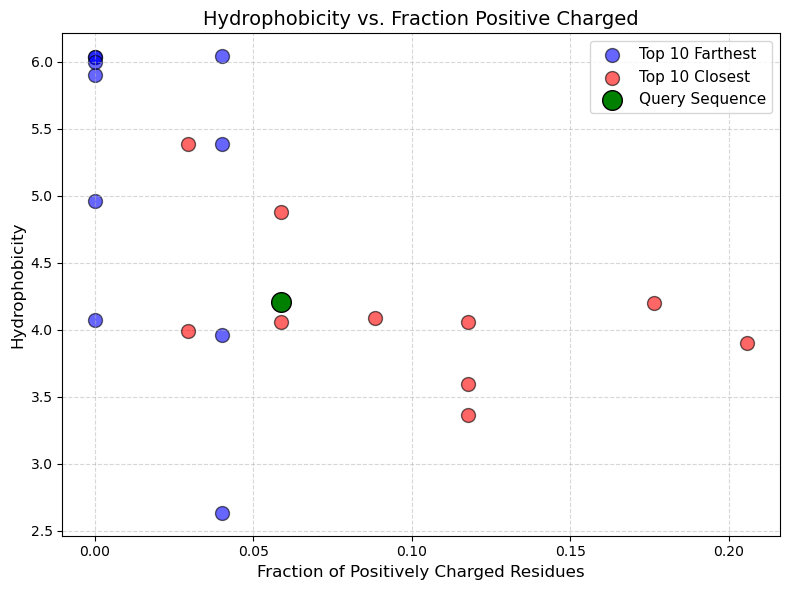

In [44]:
import matplotlib.pyplot as plt

# Prepare data
def get_props(seq_list):
    return [sparrow.Protein(i).fraction_positive for i in seq_list], [sparrow.Protein(i).hydrophobicity for i in seq_list]

x_close, y_close = get_props(sequences_closest)
x_far, y_far = get_props(sequences_far)

query = sparrow.Protein(fasta[name])
x_query, y_query = query.fraction_positive, query.hydrophobicity

# Plot
plt.figure(figsize=(8, 6))

plt.scatter(x_far, y_far, alpha=0.6, color='blue', edgecolor='k', s=100, label='Top 10 Farthest', zorder=1)
plt.scatter(x_close, y_close, alpha=0.6, color='red', edgecolor='k', s=100, label='Top 10 Closest', zorder=2)
plt.scatter(x_query, y_query, alpha=1.0, color='green', edgecolor='black', s=200, label='Query Sequence', zorder=3)

# Labels and formatting
plt.xlabel('Fraction of Positively Charged Residues', fontsize=12)
plt.ylabel('Hydrophobicity', fontsize=12)
plt.title('Hydrophobicity vs. Fraction Positive Charged', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11, frameon=True)
plt.tight_layout()
plt.show()


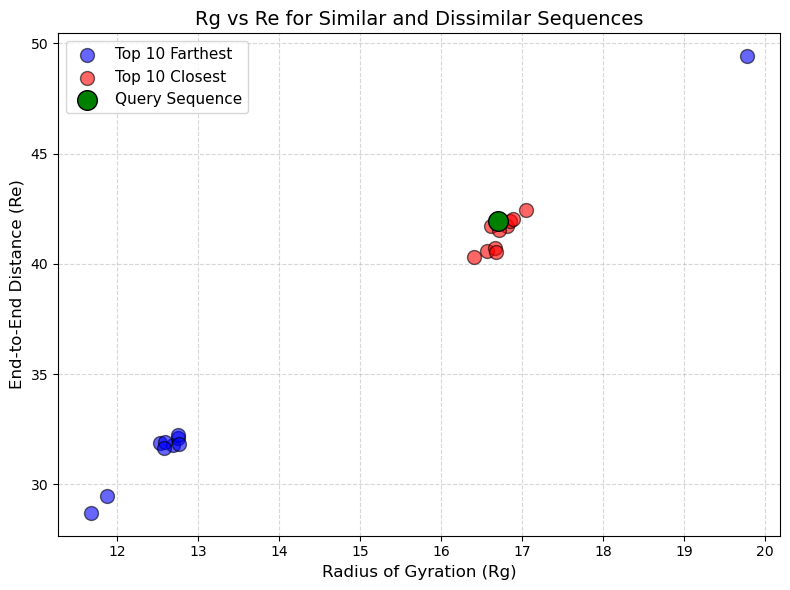

In [50]:
import matplotlib.pyplot as plt

# Query values
query_protein = sparrow.Protein(fasta[name])
query_rg = query_protein.predictor.radius_of_gyration()
query_re = query_protein.predictor.end_to_end_distance()

# Create plot
plt.figure(figsize=(8, 6))

# Farthest sequences
plt.scatter(
    rgs_far, res_far,
    alpha=0.6, color='blue', edgecolor='k',
    s=100, label='Top 10 Farthest', zorder=1
)

# Closest sequences
plt.scatter(
    rgs_closest, res_closest,
    alpha=0.6, color='red', edgecolor='k',
    s=100, label='Top 10 Closest', zorder=2
)

# Query sequence
plt.scatter(
    query_rg, query_re,
    alpha=1.0, color='green', edgecolor='black',
    s=200, label='Query Sequence', zorder=3
)

# Annotate query if desired
# plt.annotate("Query", (query_rg, query_re), textcoords="offset points", xytext=(10,10), fontsize=10)

# Labels and title
plt.xlabel('Radius of Gyration (Rg)', fontsize=12)
plt.ylabel('End-to-End Distance (Re)', fontsize=12)
plt.title('Rg vs Re for Similar and Dissimilar Sequences', fontsize=14)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11, frameon=True)
plt.tight_layout()
plt.show()


In [195]:
from sparrow.sequence_analysis import alignment

In [196]:
closest_sequences = {name: sparrow.Protein(fasta[name]) for name in closest_names}

In [203]:
alignment.SequenceAlignment(closest_sequences).display_msa

Q86UQ4_2943_3287 ------------------------------------------------------------------------------------------------------IVAEN-PSWTKDILCATLSCKQNGI-----RHLIL-SAIQG--VTLAQDHFQE--IEKIWSSPNQLNCESLSKNLS-STLESFKSSLENATGQDCTSQPRLETVQQHLYM-----------LAKSLEETWSSGNPIMTFLSNFTVTEDVKIKDL----------MKNITKLTEELRSSI-QISNETIHSILEANISHSKVLFSALTVALSGKCDQEILHLLLTFPKG---EKSWIAAEELCS------LPGSKVYSLIVLLSRN--LDVRAFIYKTLMPSEANGLLNS-----LLDIVSSLSAL--LAKAQHVFEYLP--EFLHTFKITALLETLDFQQVSQNVQARSSAFGSFQFVMKMVCKDQASFLSDSNMFINLPRVKELLEDDKEKFNIPEDST-------------------------------
A2PYH4_1091_1435 ----------------TVFYLEPKRFGNQITMQRKSETQISHSKHSDISTIAGP-NKGTTASKKPGNRECNHLCKSK-----HTCGHDCCKIGVAQKSEIKESTISS---YLSDLRNRNAVSSVPPV-----KRLKI-QMNKS----QSVDLKEF-GFTPKPSLPSISRSEYLNISEL-PIMEQWDQPEIYGKVRQEPSEYQDKEVLNVNFELGNEVWDDFDDENLEVTSFSTDTEKT--KISGFGNTLSSSTRGS------KLPLQESKSKFQREMSNSF--VSSHEMSDISLSNSAMPKFSASSMTKLPQQAGNAVIVHFQERKPQN-----LSPEIEKQCF-TFSEKNPNSSNYKKVDFFIRN-SECKKEVDFSMYHPDDEADEMKSL--LGIFDGIF--------------------------------

In [133]:
embeddings_array = np.array(list(sequence_embeddings.values())) 

names = list(sequence_embeddings.keys())

rg_values = np.array([rg[name] for name in sequence_embeddings])

re_values = np.array([re[name] for name in sequence_embeddings])

sequence_length = np.array([len(fasta[name]) for name in sequence_embeddings])

fraction_charged = np.array([sparrow.Protein(fasta[name]).fraction_positive + sparrow.Protein(fasta[name]).fraction_negative for name in sequence_embeddings])

hydrophobicity = np.array([sparrow.Protein(fasta[name]).hydrophobicity for name in sequence_embeddings])

random_indices = np.random.choice(range(0, len(embeddings_array)), size=10000, replace=False)

In [134]:
from scipy.spatial.distance import pdist, squareform

# `embeddings` is of shape (L, D)
pairwise_dist = pdist(embeddings_array[random_indices], metric='cosine')

In [135]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

# Compute linkage
Z = linkage(pairwise_dist, method='average')  # or 'ward', 'complete', etc.

# Get the optimal leaf ordering (residue indices)
leaf_order = leaves_list(Z)

In [136]:
# Reorder the distance m?atrix based on clustering
reordered = squareform(pairwise_dist)[leaf_order][:, leaf_order]

# reordered_rg = rg_values[leaf_order]

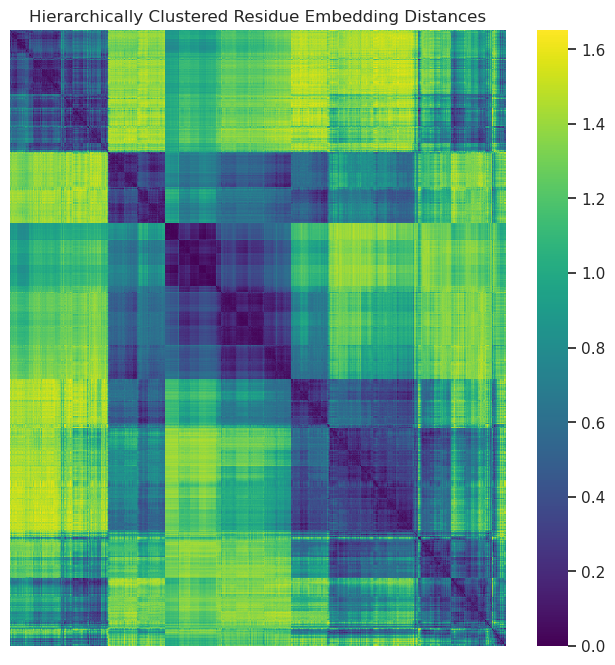

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(reordered, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Hierarchically Clustered Residue Embedding Distances')
plt.show()

In [138]:
from scipy.cluster.hierarchy import fcluster

# Extract cluster assignments using a distance threshold
# The threshold value can be adjusted based on desired number of clusters
threshold = 0.5  # This value determines the number of clusters (lower = more clusters)
cluster_labels = fcluster(Z, threshold, criterion='distance')

In [102]:
cluster1_names = np.array(names)[random_indices][cluster_labels == 2]

In [103]:
[fasta[key] for key in cluster1_names]

['MACACCMMSCSTNACCCSSMGMCSCSANQMCSCSACCGCSTCSHMCSGMSDAMCMMNNSAMCCSCSNTGCHMMMSMCCMCSSSMCGSMMSQMSQENMMCSSQSKKDHMSEMSQHCEMNSCMSAQDKMMSSSCCSNGCTTKCTMCSTCSMGHDMGGKMGEEMGKKHMMSTMGHCMSMGAMSSMCTTGEACENCMSNSECCMSTMGHEMMSGMCCSGMCCSMGCQSCTTMCCSCSGHHQKMMSSCNSMSMCCSGCTAACSMASHQMCMSMSTNMSNKCTGNDKRHQDTTQKQCMSCCSSCQT',
 'KVKKEEKKRHKSSSSSSSSSSDSDSSSDSQSSSDSSDSESATEEKSKKRKKKHRKNSRKHKKEKKKRKKSKKSASSESEAENLEAQPQSTVRPEEIPPIPENRFLMRKSPPKADEKERKNRERERERECNPPNSQPASYQRRLLVTRSGRKIKGRGPRRYRTPSRSRSRDRFRRSETPPHWRQEMQRAQRMRVSSGERWIKGDKSELNEIKENQRSPVRVKERKITDHRNVSESPNRKNEKEKKVKDHKSNSKERDIRRNSEKDDKYKNKVKKRAKSKSRSKSKEKS',
 'LMQDLDNNSITVKQRCKRKIEATGVIQSCAKEAKRILEDHGSPAGEIDDEDKDKDETETVKQTQTSEVYDGPKNVRSDISDQEEDEESEGCPVSINLSKAETQALTNYGSGEDENEDEEMEEFEEGPVDVQTSLQANTEATEENEHDEQVLQRDFKKTAESKNVPLEREATSKNDQNNCPVKPCYLNILEDEQPLNSAAHKESPPTVDSTQQPNPLPLRLPEMEPLVPRVKEVKSAQETPESSLAGSPDTESPVLVNDYEAESGNISQKSDEEDFVKVEDLPLKLTIYSEADLRKKMVEEEQKNHLSGEICEMQTEELAGNSETLKEPETVGAQSI',
 'KEAIKGNQVSFSKSTDAFAFEEDSSSDGLSPDQTRSEDPQNSAGSPPDAKASDTPSTGSL

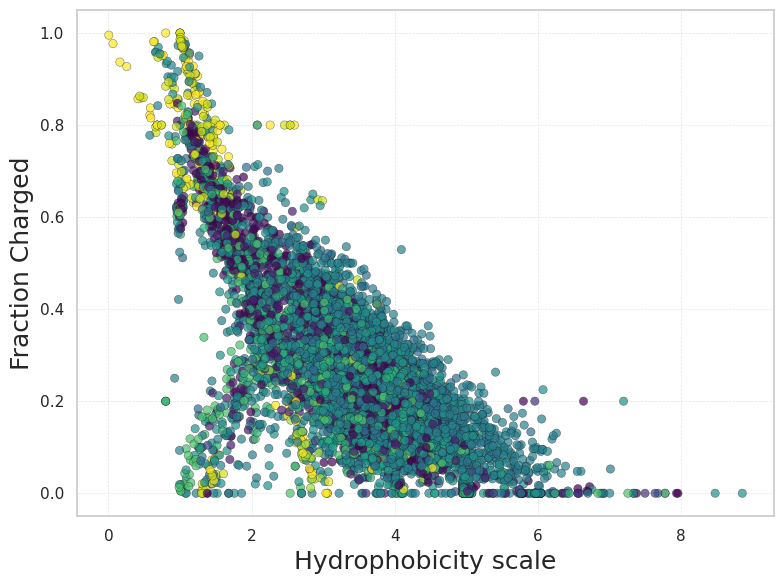

In [160]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with improved style
scatter = ax.scatter(
    hydrophobicity[random_indices],
    fraction_charged[random_indices],
    c=cluster_labels,
    cmap='viridis',
    alpha=0.7,
    edgecolors='k',
    linewidths=0.3
)

# Axis labels
ax.set_xlabel('Hydrophobicity scale', fontsize=18)
ax.set_ylabel('Fraction Charged', fontsize=18)
# ax.set_title('Clustered Protein Properties', fontsize=14, weight='bold')

# Optional colorbar for cluster labels
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Cluster Label')

# Improve layout and appearance
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


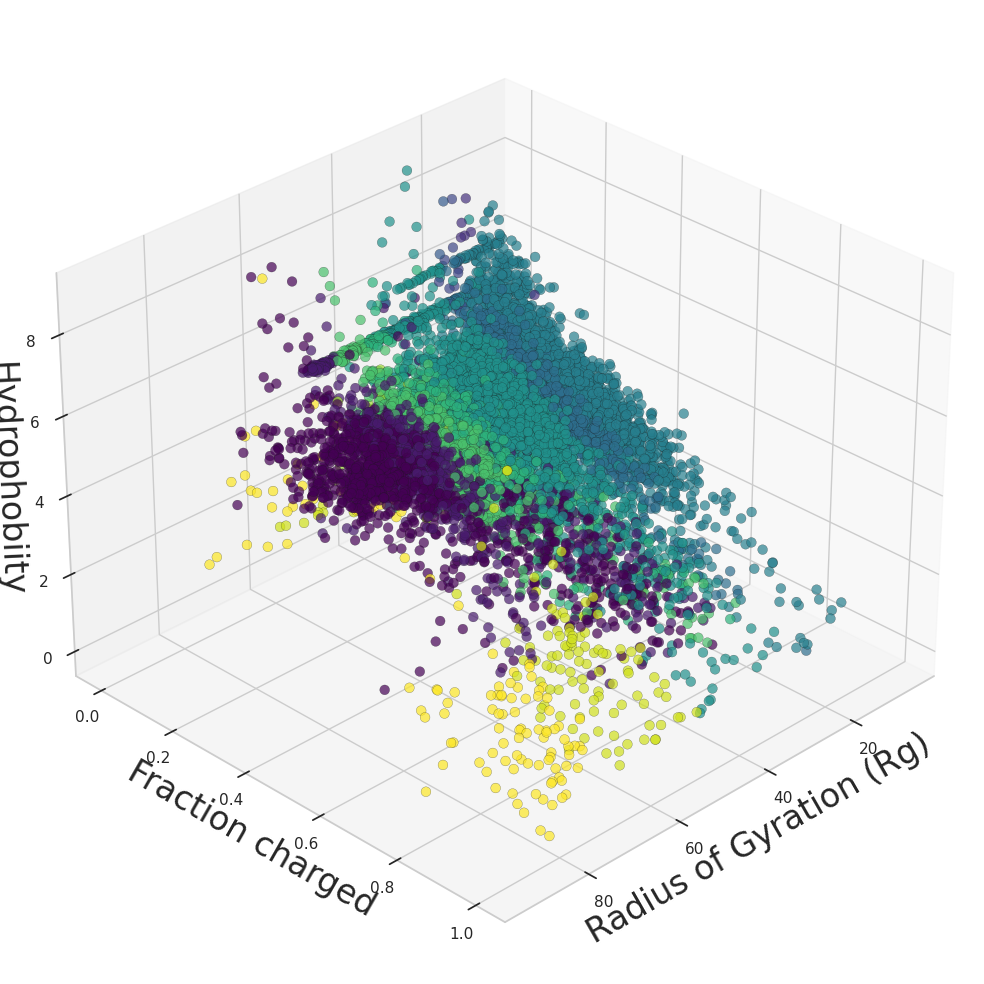

In [165]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Use the sampled indices
sampled_indices = random_indices

# Get values
x = rg_values[sampled_indices]             # End-to-End Distance
y = fraction_charged[sampled_indices]             # Radius of Gyration
z = hydrophobicity[sampled_indices]       # Sequence Length

# Plot
scatter = ax.scatter(
    x, y, z,
    c=cluster_labels, cmap='viridis',
    s=50, alpha=0.7, edgecolor='k', linewidth=0.2
)

# Labels
ax.set_xlabel('Radius of Gyration (Rg)', fontsize=24)
ax.set_ylabel('Fraction charged', fontsize=24)
ax.set_zlabel('Hydrophobiity', fontsize=24)
# plt.title('3D Visualization of Protein Properties by Cluster', fontsize=14)

# Colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label('Cluster', fontsize=12)

# View angle
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()
